<a href="https://colab.research.google.com/github/safal207/hello-world/blob/master/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BA%D1%86%D0%B8%D0%B9_%D0%9B%D1%83%D0%BA%D0%BE%D0%B9%D0%BB%D0%B0_(Time_series_Prediction_shares_of_LUKOIL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten#, Conv1D, Conv2D, CuDNNLSTM
from tensorflow.keras.layers import Conv1D, Conv2D#, 


from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import load_model

In [ ]:
#Загружаем файл базы
files.upload()
!ls

Saving CBOT.US_790901_200916.csv to CBOT.US_790901_200916.csv
CBOT.US_790901_200916.csv  sample_data


In [ ]:
!ls

CBOT.US_790901_200916.csv  sample_data


In [ ]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('CBOT.US_790901_200916.csv')

ParserError: ignored

In [ ]:
print(base_data.head())

NameError: ignored

In [ ]:
txt = base_data.values[0]
print(txt)

['03.01.2002;11:00:00;373;374.5;373;374.5;5064']


In [ ]:
def strList2Float(lst):
  return [float(i) for i in lst]

def getData(df):
  values = df.values
  
  data = []
  
  for v in values:
    currStr = v[0].split(sep=";")
    currStr = currStr[2:]
    currStr = strList2Float(currStr)
    
    data.append(currStr)
  
  return data

def getDataFromFile(fileName):
  df = pd.read_csv(fileName)
  return getData(df)

In [ ]:
data16_17 = getDataFromFile('16_17.csv')
data18_19 = getDataFromFile('18_19.csv')

In [ ]:
d = data18_19
print(len(d))
print(len(d[0]))
print(d[0])

239332
5
[373.0, 374.5, 373.0, 374.5, 5064.0]


In [ ]:
data = data16_17.copy()
data.extend(data18_19)
data = np.array(data)

In [ ]:
print(len(data16_17))
print(len(data18_19))
print(len(data))

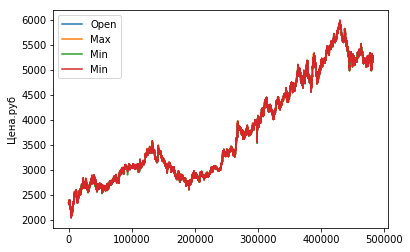

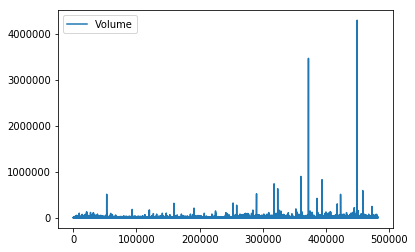

In [ ]:
#Отображаем исходные от точки start и длинной step
start = 0
step = data.shape[0]

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Min', 'Volume']

#Рисуем все графики данных
for i in range(4):
  plt.plot(data[start:start+step,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

plt.plot(data[start:start+step,4], label="Volume")
plt.legend()
plt.show()

**Функция загрузки данных**

In [ ]:
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):
  
  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (xNormalization == 0):
    xScaler = StandardScaler()
  else:
    xScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  xData = data[:,xChannels]
  #Обучаем нормировщик
  xScaler.fit(xData)
  #Нормируем данные
  xData = xScaler.transform(xData)

  #Выбираем тип нормализации y
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (yNormalization == 0):
    yScaler = StandardScaler()
  else:
    yScaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  yData = data[:,yChannels]
  #Обучаем нормировщик
  yScaler.fit(yData)
  #Нормируем данные
  yData = yScaler.transform(yData)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i+xLen, xChannels] for i in range(xData.shape[0]-xLen-1-stepsForward)])
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 0):
    yTrain = np.array([yData[i+xLen:i+xLen+stepsForward, yChannels] for i in range(yData.shape[0]-xLen-1-stepsForward)])
  else:
    yTrain = np.array([yData[i+xLen+stepsForward, yChannels] for i in range(yData.shape[0]-xLen-1-stepsForward)])

  #Делаем reshape y в зависимости от того
  #Прогнозируем на 1 шаг вперёдили на несколько
  if (stepsForward == 0):
    if ((len(yChannels) == 1)):
      yTrain = yTrain.reshape(yTrain.shape[0], 1)
  else:
      yTrain = yTrain.reshape(yTrain.shape[0], stepsForward)
  
  #Расчитыываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [ ]:
#Формируем параметры загрузки данных
xLen = 300
stepsForward = 0
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 30000
returnFlatten = 1
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(451269, 1500)
(451269, 1)
(30000, 1500)
(30000, 1)


#Полносвязная сеть

Train on 451269 samples, validate on 30000 samples
Epoch 1/20
451269/451269 [==============================] - 56s 125us/step - loss: 0.0897 - val_loss: 0.3354
Epoch 2/20
451269/451269 [==============================] - 57s 127us/step - loss: 0.0535 - val_loss: 0.0159
Epoch 3/20
451269/451269 [==============================] - 57s 126us/step - loss: 0.0386 - val_loss: 0.0276
Epoch 4/20
451269/451269 [==============================] - 58s 129us/step - loss: 0.0266 - val_loss: 0.0056
Epoch 5/20
451269/451269 [==============================] - 57s 126us/step - loss: 0.0160 - val_loss: 0.0064
Epoch 6/20
451269/451269 [==============================] - 57s 126us/step - loss: 0.0101 - val_loss: 0.0016
Epoch 7/20
451269/451269 [==============================] - 57s 126us/step - loss: 0.0061 - val_loss: 0.0041
Epoch 8/20
451269/451269 [==============================] - 57s 127us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 9/20
451269/451269 [==============================] - 57s 127us/step - 

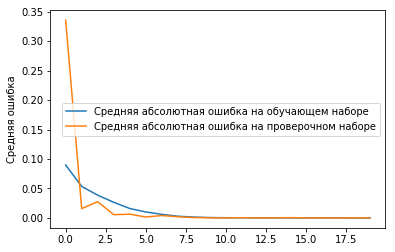

In [ ]:
modelD = Sequential()

modelD.add(Dense(100, input_dim = xTrain.shape[1], activation="linear"))
#modelD.add(Dense(100, activation="linear"))
#modelD.add(Dense(100, activation="linear"))
modelD.add(Dense(yTrain.shape[1], activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelD.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=20, 
                    verbose=1, 
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

#Визуализация результатов

In [ ]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
#Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисуем корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    plt.plot(corr, 
               label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

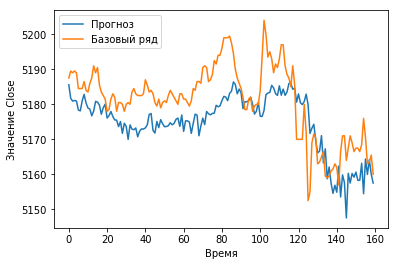

In [ ]:
#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

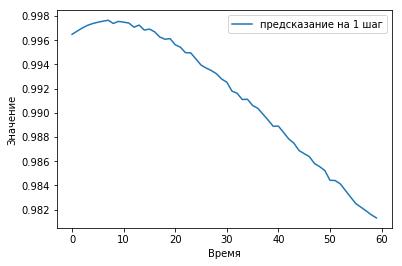

In [ ]:
#Отображаем корреляцию
showCorr([0], 60, predVal, yValUnscaled)

#Одномерная свёртка

In [ ]:
#Формируем параметры загрузки данных
xLen = 300
stepsForward = 0
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 30000
returnFlatten = 0
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(451269, 300, 5)
(451269, 1)
(30000, 300, 5)
(30000, 1)


In [ ]:
modelC = Sequential()

modelC.add(Conv1D(50, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
#modelC.add(Conv1D(100, 5, activation="linear"))
#modelC.add(Conv1D(100, 5, activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(10, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit(xTrain, 
                    yTrain, 
                    epochs=20, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Train on 451269 samples, validate on 30000 samples
Epoch 1/20
451269/451269 [==============================] - 81s 180us/step - loss: 0.1830 - val_loss: 0.0147
Epoch 2/20
451269/451269 [==============================] - 80s 177us/step - loss: 0.0110 - val_loss: 6.0212e-04
Epoch 3/20
451269/451269 [==============================] - 80s 177us/step - loss: 3.5009e-04 - val_loss: 4.4080e-05
Epoch 4/20
451269/451269 [==============================] - 78s 173us/step - loss: 1.3562e-04 - val_loss: 1.9861e-05
Epoch 5/20
451269/451269 [==============================] - 78s 174us/step - loss: 9.7420e-05 - val_loss: 1.9137e-05
Epoch 6/20
451269/451269 [==============================] - 80s 177us/step - loss: 7.5088e-05 - val_loss: 1.9513e-05
Epoch 7/20
451269/451269 [==============================] - 79s 175us/step - loss: 6.3792e-05 - val_loss: 2.5423e-05
Epoch 8/20
451269/451269 [==============================] - 79s 174us/step - loss: 5.1529e-05 - val_loss: 1.1708e-05
Epoch 9/20
451269/451269 

KeyboardInterrupt: ignored

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

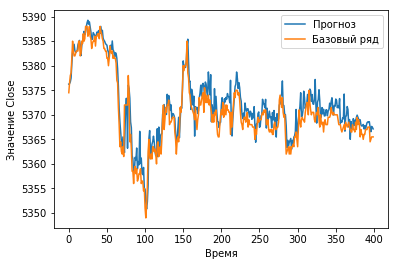

In [ ]:
#Отображаем графики
showPredict(10000, 400, 0, predVal, yValUnscaled)

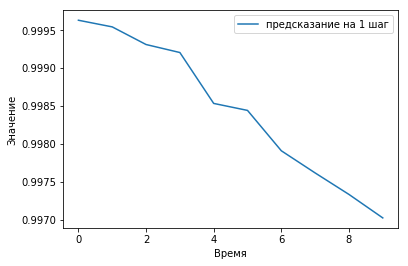

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

#LSTM

In [ ]:
modelL = Sequential()
#modelL.add(CuDNNLSTM(5, input_shape = (xTrain.shape[1], xTrain.shape[2])))
modelL.add(CuDNNLSTM(100, input_shape = (xTrain.shape[1], xTrain.shape[2]), return_sequences="True"))
modelL.add(CuDNNLSTM(100, return_sequences="True"))
modelL.add(CuDNNLSTM(100, return_sequences="True"))
modelL.add(Flatten())
modelL.add(Dense(100, activation="linear"))
modelL.add(Dense(yTrain.shape[1], activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelL.fit(xTrain, 
                    yTrain, 
                    epochs=100, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelL
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

#ModelX
**Сложная сеть из LSTM и Conv1D слоёв на старте и Dense слоёв в конце**

In [ ]:
dataInput = Input(shape=(xTrain.shape[1], xTrain.shape[2]))

lstmWay = CuDNNLSTM(10, return_sequences="True")(dataInput)
convWay = Conv1D(10, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(10, 5, activation="relu")(lstmWay)
convLstmWay = CuDNNLSTM(10, return_sequences="True")(convWay)

lstmWay = CuDNNLSTM(10, return_sequences="True")(lstmWay)
convWay = Conv1D(10, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

modelX.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelX.fit(xTrain, 
                    yTrain, 
                    epochs=6, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Train on 451269 samples, validate on 30000 samples
Epoch 1/6
451269/451269 [==============================] - 893s 2ms/step - loss: 0.0031 - val_loss: 1.9150e-04
Epoch 2/6
451269/451269 [==============================] - 897s 2ms/step - loss: 1.3096e-04 - val_loss: 2.6749e-04
Epoch 3/6
451269/451269 [==============================] - 907s 2ms/step - loss: 7.5632e-05 - val_loss: 9.6144e-05
Epoch 4/6
451269/451269 [==============================] - 903s 2ms/step - loss: 4.9595e-05 - val_loss: 6.3490e-05
Epoch 5/6
451269/451269 [==============================] - 908s 2ms/step - loss: 3.7592e-05 - val_loss: 4.4688e-05
Epoch 6/6
155980/451269 [=========>....................] - ETA: 9:32 - loss: 3.2314e-05Buffered data was truncated after reaching the output size limit.

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

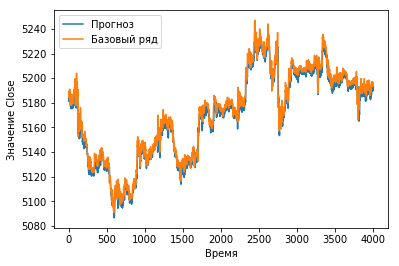

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

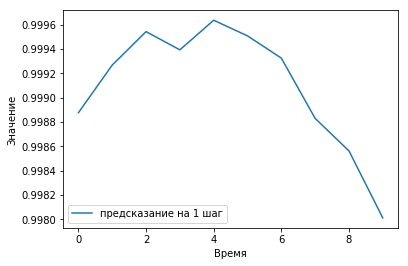

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)